In [32]:
import matplotlib.pyplot as plt
import cv2


import scipy

from pathlib import Path

import numpy as np

import h5py
import math


import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import holoviews as hv

import platform

import sys
sys.path.insert(0, "../../..")

from pathlib import Path

import cv2

import json

import bokeh.io
import bokeh.models
import bokeh.plotting

import bokeh

bokeh.io.output_notebook()


from Utilities.Utils import *
from Utilities.Processing import *

Loading BokehJS ...

In [3]:
ballpath = Path('/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3_tracked.000_corridor3.analysis.h5')

flypath = Path('/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/flytrack.000_corridor3.analysis.h5')

vidpath = Path('/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3.mp4')



In [4]:
# import the h5 file

with h5py.File(ballpath.as_posix(), "r") as f:
            dset_names = list(f.keys())
            ball_locs = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]

In [5]:
with h5py.File(flypath.as_posix(), "r") as f:
            dset_names = list(f.keys())
            fly_locs = f["tracks"][:].T
            node_names = [n.decode() for n in f["node_names"][:]]

In [6]:
yball = ball_locs[:, :, 1, :]
xball = ball_locs[:, :, 0, :]


yfly = fly_locs[:, :, 1, :]
xfly = fly_locs[:, :, 0, :]

In [7]:
import numpy as np

def replace_nans_with_previous_value(arr):
    # Find the indices of the NaN values
    nan_indices = np.where(np.isnan(arr))

    # Replace the NaN values with the previous value
    for i in nan_indices[0]:
        arr[i] = arr[i-1]

# Replace NaNs in yball
replace_nans_with_previous_value(yball)

# Replace NaNs in xball
replace_nans_with_previous_value(xball)

# Replace NaNs in yfly
replace_nans_with_previous_value(yfly)

# Replace NaNs in xfly
replace_nans_with_previous_value(xfly)


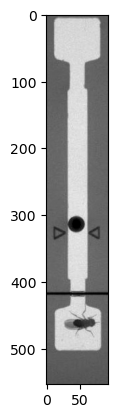

In [8]:
# Load the first frame of the video and display it
cap = cv2.VideoCapture(vidpath.as_posix())
ret, frame = cap.read()
if ret:
    plt.imshow(frame)
    plt.show()
else:
    print('Error: Could not read frame from video')
    

In [23]:
import cv2
import numpy as np

def create_marked_video(video_path, xfly, yfly, xball, yball, start_frame, end_frame, output_path):
    # Open the input video file
    cap = cv2.VideoCapture(video_path)
    
    # Get the video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Create the output video file
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Set the position of the video to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Process each frame of the video
    for i in range(start_frame, end_frame+1):
        # Read the next frame from the input video
        ret, frame = cap.read()
        
        # Check if the frame was successfully read
        if not ret:
            break
        
        # Get the positions of the fly and ball in this frame
        fly_pos = (int(xfly[i]), int(yfly[i]))
        ball_pos = (int(xball[i]), int(yball[i]))
        
        # Draw a circle at each position
        cv2.circle(frame, fly_pos, 5, (0, 0, 255), -1)
        cv2.circle(frame, ball_pos, 5, (255, 0, 0), -1)
        
        # Draw a larger circle around the ball marker
        cv2.circle(frame, ball_pos, 12, (255, 0, 0), 2)
        
        # Write the frame to the output video
        out.write(frame)
    
    # Release the video capture and writer
    cap.release()
    out.release()



In [28]:
outpath = Path('/mnt/labserver/DURRIEU_Matthias/Videos/ballflytrack_sample.mp4')

create_marked_video(vidpath.as_posix(), xfly, yfly, xball, yball, 66600, 72000, outpath.as_posix())


In [9]:
yball_smooth = savgol_lowpass_filter(yball, 221, 1)

yfly_smooth = savgol_lowpass_filter(yfly, 221, 1)



ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [10]:
import numpy as np
import pandas as pd

# Combine the yball and yfly arrays into a single 2D array
data = np.stack((yball.squeeze(), yfly.squeeze()), axis=1)

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=['yball', 'yfly'])

# Display the first few rows of the DataFrame
print(df.head())


        yball        yfly
0  312.864868  461.939789
1  312.902557  462.152802
2  312.834259  459.754120
3  312.923767  459.604584
4  312.914856  459.899689


In [11]:
start, end = np.load(vidpath.parent / 'coordinates.npy')

#df['yball_relative'] = abs(df['yball'] - start)

#df['yfly_relative'] = abs(df['yfly'] - start)

df['yball_smooth'] = savgol_lowpass_filter(df['yball'], 221, 1)

df['yfly_smooth'] = savgol_lowpass_filter(df['yfly'], 221, 1)

df = df.assign(Frame=df.index + 1)


df["time"] = df["Frame"] / 30

df.head()

,yball,yfly,yball_smooth,yfly_smooth,Frame,time
0,312.864868,461.939789,313.494617,465.967944,1,0.033333
1,312.902557,462.152802,313.493949,466.024429,2,0.066667
2,312.834259,459.754120,313.493281,466.080914,3,0.100000
3,312.923767,459.604584,313.492613,466.137399,4,0.133333
4,312.914856,459.899689,313.491945,466.193885,5,0.166667


In [ ]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

# Create a Holoviews Curve for each data series
yball_curve = hv.Curve((df['time'], df['yball']), label='yball').opts(color='lightblue')
yball_smooth_curve = hv.Curve((df['time'], df['yball_smooth']), label='yball_smooth').opts(color='blue')
yfly_curve = hv.Curve((df['time'], df['yfly']), label='yfly').opts(color='lightcoral')
yfly_smooth_curve = hv.Curve((df['time'], df['yfly_smooth']), label='yfly_smooth').opts(color='red')

# Overlay the curves to create the final plot
plot = yfly_smooth_curve * yball_smooth_curve #yball_curve * yfly_curve

# Set some options for the plot
plot.opts(
    opts.Curve(width=1200, height=800, invert_yaxis=True, fontsize={'title': 16, 'labels': 14, 'xticks': 12, 'yticks': 12},
               xlabel='Time (s)', ylabel='Y Position (pixels)', title='Fly and Ball Y Positions'),
    opts.Overlay(legend_position='top_left')
)

# Display the plot
plot

# TODO: revert y-axis

In [13]:
# Compute the difference between the yball and yfly positions smoothed

df['dist'] =  df['yfly_smooth'] - df['yball_smooth']

In [14]:
Thresh = 80

# Locate where the distance is below the threshold
df['close'] = df['dist'] < Thresh

In [15]:
df['close']

0         False
1         False
2         False
3         False
4         False
          ...  
215995     True
215996     True
215997     True
215998     True
215999     True
Name: close, Length: 216000, dtype: bool

In [16]:
df = df.reset_index()

# Find the start and end indices of streaks of True values in the 'close' column
df['block'] = (df['close'].shift(1) != df['close']).cumsum()
events = df[df['close']].groupby('block').agg(start=('index', 'min'), end=('index', 'max'))

# Store the interaction events as separate DataFrames
interaction_events = [df.loc[start:end] for start, end in events[['start', 'end']].itertuples(index=False)]

# You can then use these DataFrames to generate your grid video

In [17]:
interaction_events

[      index       yball        yfly  yball_smooth  yfly_smooth  Frame  \
 565     565  312.963684  367.638824    313.117813   393.102942    566   
 566     566  312.934631  367.548584    313.110161   392.843159    567   
 567     567  312.955841  363.386719    313.109976   392.572033    568   
 568     568  312.911713  363.087036    313.109778   392.300807    569   
 569     569  312.915619  363.346710    313.109594   392.040941    570   
 ...     ...         ...         ...           ...          ...    ...   
 1827   1827  326.663391  381.730225    326.779094   404.709576   1828   
 1828   1828  326.671783  379.410217    326.786520   405.187254   1829   
 1829   1829  326.616699  383.759552    326.786520   405.667098   1830   
 1830   1830  326.684357  384.086792    326.786551   406.165327   1831   
 1831   1831  326.614471  386.229126    326.786484   406.653375   1832   
 
            time       dist  close  block  
 565   18.866667  79.985130   True      2  
 566   18.900000  79.7

In [43]:
interaction_events[0]

,index,yball,yfly,yball_smooth,yfly_smooth,Frame,time,dist,close,block
565,565,312.963684,367.638824,313.117813,393.102942,566,18.866667,79.985130,True,2
566,566,312.934631,367.548584,313.110161,392.843159,567,18.900000,79.732999,True,2
567,567,312.955841,363.386719,313.109976,392.572033,568,18.933333,79.462057,True,2
568,568,312.911713,363.087036,313.109778,392.300807,569,18.966667,79.191029,True,2
569,569,312.915619,363.346710,313.109594,392.040941,570,19.000000,78.931347,True,2
...,...,...,...,...,...,...,...,...,...,...
1827,1827,326.663391,381.730225,326.779094,404.709576,1828,60.933333,77.930482,True,2
1828,1828,326.671783,379.410217,326.786520,405.187254,1829,60.966667,78.400734,True,2
1829,1829,326.616699,383.759552,326.786520,405.667098,1830,61.000000,78.880579,True,2
1830,1830,326.684357,384.086792,326.786551,406.165327,1831,61.033333,79.378776,True,2


In [18]:
# get the length of each event
event_lengths = [len(event) for event in interaction_events]

print(event_lengths)

[1267, 171, 200, 198, 438, 179, 235, 332, 156, 26, 317, 152, 189, 161, 201, 193, 265, 262, 320, 72, 134, 902, 429, 444, 523, 416, 219, 380, 183, 93, 83, 290, 453, 1441, 1409, 136, 213, 270, 2148, 249, 618, 160, 302, 228, 119, 606, 1070, 396, 800, 149, 513, 110, 281, 251, 659, 34, 643, 148, 1872, 218, 94, 493, 196, 134, 232, 1194, 422, 42, 115, 108, 882, 601, 75, 802, 1672, 347, 276, 259, 320, 132, 271, 146, 431, 327, 629, 283, 193, 153, 481, 1029, 584, 1138, 549, 1261, 2885, 598, 188, 374, 1243, 51, 283, 123, 42, 661, 660, 364, 88, 213, 349, 306, 174, 168, 86, 117, 52, 673, 341, 206, 223, 258, 327, 439, 1231, 920, 53, 394, 426, 264, 67, 265, 177, 70, 251, 52, 619, 13, 190, 111, 259, 256, 265, 50, 108, 375, 204, 130, 11, 677, 108, 24, 283, 377, 251, 54, 81, 410, 182, 1580, 135, 876, 221, 571, 47, 112, 332, 495, 75, 439, 121, 162, 81, 119, 118, 140, 352, 198, 49, 178, 88, 140, 85, 94, 98, 383, 462, 195, 66, 576, 198, 152, 86, 60, 20, 191, 35, 133, 41, 459, 39, 69, 440, 63, 44, 266, 208, 

In [19]:
# remove events that are less than 60 frames long
interaction_events = [event for event in interaction_events if len(event) >= 60]

# Example usage
event_times = [(df['time'].min(), df['time'].max()) for df in interaction_events]

Plotting ball movements in each interaction event

In [45]:
from bokeh.layouts import gridplot
from bokeh.layouts import row, column, layout

from bokeh.plotting import figure

from math import ceil, sqrt


min_y = min(df['yfly_smooth'].min(), df['yball_smooth'].min()) - 10
max_y = max(df['yfly_smooth'].max(), df['yball_smooth'].max()) + 10

min_x = df['time'].min()
max_x = df['time'].max()

# Define a list to store the plots
plots = []

# Loop over the interaction events
for i, event in enumerate(interaction_events):
    # Create a new figure for the current event
    p = figure(width=400, height=300)
    
    # Add a line for the 'yfly_smooth' column
    p.line(event['time'], event['yfly_smooth'], color='blue', legend_label='yfly_smooth')
    
    # Add a line for the 'yball_smooth' column
    p.line(event['time'], event['yball_smooth'], color='red', legend_label='yball_smooth')
    
    # Set the same y range for both lines
    p.y_range.start = min_y
    p.y_range.end = max_y
    
    # Set the same x range for both lines
    # p.x_range.start = min_x
    # p.x_range.end = max_x
    
    # Set the title to be the event number and time in the video
    p.title.text = f'Event {i+1} ({event_times[i][0]:.1f} - {event_times[i][1]:.1f} s)'
    
    # Reverse the y-axis
    p.y_range.flipped = True
    
        # Add the plot to the list of plots
    plots.append(p)

# Determine grid shape
num_plots = len(plots)
grid_size = ceil(sqrt(num_plots))  # This creates a roughly square grid

# Reshape list of plots into grid shape
plots_grid = [plots[i:i+grid_size] for i in range(0, num_plots, grid_size)]

# Create a grid of plots
grid = gridplot(plots_grid)
# Show the grid
#bokeh.io.show(grid)


In [46]:
DataPath = Path("/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Datasets")

bokeh.plotting.save(grid, DataPath / "Plots/230913_BallInteractions_curves.html")

/home/durrieu/miniconda3/envs/Main/lib/python3.10/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/durrieu/miniconda3/envs/Main/lib/python3.10/site-packages/bokeh/io/saving.py:154: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Datasets/Plots/230913_BallInteractions_curves.html'

New writing clips

In [49]:
def write_clip_wholecrop(input_path, start_frame, end_frame, output_path, df):
    """
    Writes a clip from the input video to the output video. 
    In this version, the video is only cropped once based on the min and max values of the yfly_smooth and yball_smooth columns.

    Parameters
    ----------
    input_path : str
        The path to the input video.
    start_frame : int
        The start frame of the clip.
    end_frame : int
        The end frame of the clip.
    output_path : str
        The path to the output video.

    Returns
    -------
    None
    """
    # Open the input video
    input_video = cv2.VideoCapture(input_path)
    fps = input_video.get(cv2.CAP_PROP_FPS)
    frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Set the position of the input video to the start frame
    input_video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    output_video = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, 140))

    # Calculate the cropping region based on min and max values of 'yfly_smooth' and 'yball_smooth'
    y_min = int(df[['yfly_smooth', 'yball_smooth']].min().min() - 20)
    y_max = int(df[['yfly_smooth', 'yball_smooth']].max().max() + 120)

    # Iterate over the frames of the input video
    for frame_number in range(start_frame, end_frame + 1):
        # Read the next frame from the input video
        ret, frame = input_video.read()
        if not ret:
            break

        # Crop the frame
        cropped_frame = frame[y_min:y_max, :]

        # Resize the cropped frame to match the original frame size
        resized_frame = cv2.resize(cropped_frame, (frame_width, 140))

        # Write the resized frame to the output video
        output_video.write(resized_frame)

    # Release the input and output videos
    input_video.release()
    output_video.release()

OutFolder = Path("/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Grids/Newcrop")
   
for i, event in enumerate(interaction_events):
    start_frame = event["Frame"].min()
    end_frame = event["Frame"].max()
    output_path = OutFolder / f"interaction_event_{i}.mp4"
    #print(outpath)
    write_clip_wholecrop(vidpath.as_posix(), start_frame, end_frame, output_path.as_posix(), event)

In [48]:
OutFolder / f"interaction_event_{i}.mp4"

PosixPath('/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Grids/Newcrop/interaction_event_0.mp4')

In [ ]:
from moviepy.editor import VideoFileClip, clips_array

def create_grid_video(input_path, event_times, output_path=None):
    # Load the input video
    input_video = VideoFileClip(input_path)

    # Extract the video chunks corresponding to each event
    clips = [input_video.subclip(start_time, end_time) for start_time, end_time in event_times]

    # Create a grid from the clips
    grid = clips_array([clips])

    # Set the output path for the grid video
    if not output_path:
        output_path = "grid.mp4"

    # Write the grid video to a file
    grid.write_videofile(output_path)

# Example usage
event_times = [(df['time'].min(), df['time'].max()) for df in interaction_events]

vidpath = Path('/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3.mp4')
outpath = Path('/mnt/labserver/DURRIEU_Matthias/Videos/EventsGrid.mp4')


  # start and end times of the events in seconds
create_grid_video(input_path='/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3.mp4', 
                  event_times = event_times, 
                  output_path='/mnt/labserver/DURRIEU_Matthias/Videos/EventsGrid.mp4')


In [ ]:
from joblib import Parallel, delayed
from moviepy.editor import VideoFileClip
event_times = [(df['time'].min(), df['time'].max()) for df in interaction_events]

def write_clip(input_path, start_time, end_time, output_path):
    # Load the input video
    input_video = VideoFileClip(input_path)

    # Extract the video chunk corresponding to the event
    clip = input_video.subclip(start_time, end_time)

    # Write the video clip to a file
    clip.write_videofile(output_path)

# Example usage
input_path = '/mnt/labserver/DURRIEU_Matthias/Experimental_data/MultiMazeRecorder/Videos/230721_Feedingstate_4_PM_Videos_Tracked/arena5/corridor3/corridor3.mp4'
event_times = event_times  # start and end times of the events in seconds
output_paths = [f'/mnt/labserver/DURRIEU_Matthias/Videos/GridClips/clip_{i}.mp4' for i in range(len(event_times))]

# Write the individual video clips in parallel
Parallel(n_jobs=-1)(
    delayed(write_clip)(input_path, start_time, end_time, output_path)
    for (start_time, end_time), output_path in zip(event_times, output_paths)
)


In [ ]:
from moviepy.editor import VideoFileClip, clips_array


# Load the individual video clips
clips = [VideoFileClip(file_path) for file_path in output_paths]

# Create a grid from the clips
grid = clips_array([clips])

# Set the output path for the grid video
outpath = Path('/mnt/labserver/DURRIEU_Matthias/Videos/EventsGrid2.mp4')

# Write the grid video to a file
grid.write_videofile(outpath.as_posix(), fps = 30, codec='libx264', audio=False)


In [23]:
# Check if all events have different start and end times
all_valid = all(start_time != end_time for start_time, end_time in event_times)

if all_valid:
    print("All events have different start and end times.")
else:
    print("Some events have the same start and end times.")


All events have different start and end times.
